### **1. Import all neccessery libraries.**

In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import json
import calendar
from matplotlib.colors import to_rgba
import numpy as np
from scipy.stats import norm
from scipy.stats import mannwhitneyu

### **2. Get data.**

    From GoogleCloud and create a Data Frame 'df'.
    This Data Set consists of first new wallets's outgoing transactions in 2023.
    There is a sample which was chosen like 20000 fist raws from 1% sample of table `all_new_wallets_2023`

NOTE:

    'first_transactions_sample_with_input' was previously created with SQL-queries on BigQuery.
    All queries are saved in query_ethereum_project.txt

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'my-project-444222-1be5aecf7dbb.json'

In [69]:
client = bigquery.Client()

query = """
SELECT *
FROM `my-project-444222.wallets_2023.first_transactions_sample_with_input`
"""
df = client.query(query).to_dataframe()

### **3. Check DataFrame.**

In [4]:
df.head(5)

,from_address,first_transaction_time,to_address,value,input,gas,gas_price,transaction_type,receipt_gas_used
0,0x6475e88ef19683a1345866398f45ab2549dbd621,2023-01-20 23:53:23+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,0xa9059cbb000000000000000000000000bb3fd383d1c5...,63429,25123969051,0,43725
1,0x49a64a902c99bf44e159d17a8b334d0c054dc612,2023-11-04 02:29:35+00:00,0xdef1c0ded9bec7f1a1670819833240f027b25eff,2718019107674500.000000000,0x3598d8ab000000000000000000000000000000000000...,171677,13626377233,2,140381
2,0xa6481f04f959be573f85bafa962dd5716c75036f,2023-02-13 07:51:59+00:00,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,0E-9,0xa9059cbb000000000000000000000000c610ff51929c...,316657,14899917470,2,226075
3,0x8f0ab55f38f530345d271600eb3c0d08c1df19df,2023-06-12 12:18:11+00:00,0x8e16bf47065fe843a82f4399baf5abac4e0822b7,0E-9,0xa9059cbb000000000000000000000000c30badb28e20...,62243,15750000000,0,56963
4,0x92508951402cf163ace0e23424b1d888e13c093b,2023-09-14 13:06:59+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,0xa9059cbb0000000000000000000000001689a089aa12...,170000,33000000000,0,43701


In [5]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   from_address            20000 non-null  object             
 1   first_transaction_time  20000 non-null  datetime64[us, UTC]
 2   to_address              19867 non-null  object             
 3   value                   20000 non-null  object             
 4   input                   20000 non-null  object             
 5   gas                     20000 non-null  Int64              
 6   gas_price               20000 non-null  Int64              
 7   transaction_type        20000 non-null  Int64              
 8   receipt_gas_used        20000 non-null  Int64              
dtypes: Int64(4), datetime64[us, UTC](1), object(4)
memory usage: 1.4+ MB


(None, (20000, 9))

**"to_address - STRING - NULLABLE - Address of the receiver. null when its a contract creation transaction"** - here is description from origin table `bigquery-public-data.crypto_ethereum.transactions`  
It means all addresses ('from_address') with NULL in the column 'to_address' belong to Contracts.  

Replace NULL with 'Contract':

In [70]:
df = df.fillna('Contract')

Change 'value' data type:

In [71]:
df['value'] = pd.to_numeric(df['value'], errors='coerce')

### **4. Extract Bytes Signatures from Input and Decode Them.**

* Bytes Signature  - first 10 symbols of an input. It can be decoded into readable Text Signature with fuction's name
* Function - action, wich Smart Contract executes
* Smart Contract -
* If Signature is 0x it means tranaction doesn’t relate to Smart Contract and it defines as Transfer (between two wallets)

In [72]:
df['signature'] = df['input'].str[:10]

In [73]:
unique_signatures = df['signature'].unique()
df['signature'].value_counts().head(5)

signature
0x            8770
0xa9059cbb    5087
0x095ea7b3     974
0xeb672419     859
0x3593564c     401
Name: count, dtype: int64

In [74]:
def get_function(signature_list):
    """
    Decodes a list of Ethereum function signatures using the 4byte.directory API.

    Args:
        signature_list (list): List of hexadecimal function signatures (e.g., ['0x095ea7b3']).

    Returns:
        dict: A dictionary mapping each signature to its decoded function name or 'Unknown'.
    """
    decoded = {}
    for signature in signature_list:
        if signature == '0x':
            decoded[signature] = 'Transfer'
            continue 
        url = f"https://www.4byte.directory/api/v1/signatures/?hex_signature={signature}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json().get('results', [])
            decoded[signature] = results[0]['text_signature'] if results else "Unknown"
        else:
            decoded[signature] = "API error"
    return decoded


In [75]:
decoded_results = get_function(unique_signatures)

In [76]:
df['function'] = df['signature'].map(decoded_results)

In [77]:
df.function.value_counts().head(5)

function
Transfer                                                                       8770
workMyDirefulOwner(uint256,uint256)                                            5087
_SIMONdotBLACK_(int8[],int224[],int256,int64,uint248[])                         974
requestL2Transaction(address,uint256,bytes,uint256,uint256,bytes[],address)     859
Unknown                                                                         781
Name: count, dtype: int64

**Some the names of funtions don't look as expected, because of collision in Bytes Code (when different texts have the same Bytes Code)**

**Signatures was checked on https://www.4byte.directory/ and Function's name was changed**

In [78]:
def fixed_func_names(func_name):
    if func_name == 'workMyDirefulOwner(uint256,uint256)':
        return 'transfer(address,uint256)'
    elif func_name == '_SIMONdotBLACK_(int8[],int224[],int256,int64,uint248[])':
        return 'approve(address,uint256)'
    elif func_name == 'join_tg_invmru_haha_9f4805a(bool,uint256)':
        return 'swapExactETHForTokensSupportingFeeOnTransferTokens(uint256,address[],address,uint256)'
    return func_name

df['function'] = df['function'].apply(fixed_func_names)

In [79]:
df.function.value_counts().head(6)

function
Transfer                                                                       8770
transfer(address,uint256)                                                      5087
approve(address,uint256)                                                        974
requestL2Transaction(address,uint256,bytes,uint256,uint256,bytes[],address)     859
Unknown                                                                         781
execute(bytes,bytes[],uint256)                                                  401
Name: count, dtype: int64

It can be suggested that excluding 87770 Transfers are between wallets, other transactions belong Smart Contracts or inner blockchain processes.

### **5. Analisis of the First Transactions Purposes**

Exclude Contract's adresses:

In [80]:
df[df['function'] == 'Transfer'].describe()

,value,gas,gas_price,transaction_type,receipt_gas_used
count,8.770000e+03,8770.0,8770.0,8770.0,8770.0
mean,9.822688e+18,27576.715165,32202855570.149033,1.278107,21320.169555
std,4.918961e+20,30545.965764,29711920906.699932,0.96007,5236.021528
min,0.000000e+00,21000.0,4740000000.0,0.0,21000.0
25%,2.074420e+16,21000.0,17000000000.0,0.0,21000.0
50%,6.364410e+16,21000.0,25001539939.5,2.0,21000.0
75%,2.356489e+17,21000.0,38000000000.0,2.0,21000.0
max,3.131060e+22,978136.0,1176000000000.0,2.0,270353.0


The dataset contains heterogeneous data.  

*min value is 0.00*

***why somebody transfed 0 (zero) ETH if it is NOT a contract?***

#### **5.1 How Many Zero Transactions among User Transfers?**

In [81]:
df[(df['function'] == 'Transfer') & (df['value'] == 0.00)].shape[0]

92

#### **5.2 Detailed Analysis of User-to-User Transfers with 0 ETH values**

In [82]:
df[(df['function'] == 'Transfer') & (df['value'] == 0.00)].to_address.value_counts().head(3)

to_address
0xb6b039afc0ce83ddf613d6b742eba3b96943df0e    30
0x2b82c78ae3c973c1ce39d63b5d63c6cb8db199ea    18
0x34806cbba5698f9ca9f4aa4700348e56fe3ceb34     8
Name: count, dtype: int64

A detailed analysis of transactions classified as User-to-User Transfers (due to a zero input) revealed that some of them have a zero value. This raised a question: **what is the purpose of sending 0 ETH between users?**

To investigate further, the two most popular recipient addresses of such transactions were checked via the Etherscan interface: 

[1st address (30 transactions)](https://etherscan.io/address/0xb6b039afc0ce83ddf613d6b742eba3b96943df0e)  
[2nd address (18 transactions)](https://etherscan.io/address/0x2b82c78ae3c973c1ce39d63b5d63c6cb8db199ea)

The results showed that these addresses belong to contracts, even though the transactions have a zero input. This indicates that certain contracts may perform functions that do not involve direct ETH transfers and for some reasons don’t have typically function's patterns in an input but still interact with the blockchain.

***Additional Analysis***  
Based on this finding, 48 transactions with a zero value were examined, and all of them turned out to be transactions to contract addresses. Therefore, it is reasonable to assume that the remaining transactions in this group (92 in total) are also contract-related.

***Conclusion***  
While a zero input is typically used to classify transactions as User-to-User Transfers, a detailed analysis revealed that this criterion is not always sufficient. Some transactions with zero input and zero value are actually directed to contracts performing specific functions.

To ensure accurate classification of such transactions, additional checks of recipient addresses or identifying typical contract patterns are necessary. This approach can help avoid misclassification and provide a better understanding of blockchain interactions.

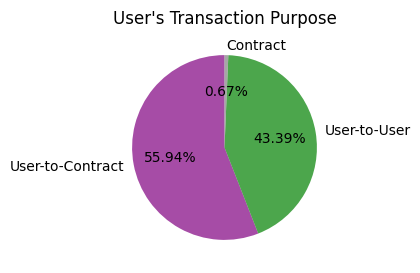

In [147]:
def transfer_or_contract(row):
    if row['to_address'] == 'Contract':
        return 'Contract'
    elif row['function'] == 'Transfer' and row['value'] != 0.00 and row['to_address'] != 'Contract':
        return 'User-to-User'    
    return 'User-to-Contract'

df['transactions_purpose'] = df.apply(transfer_or_contract, axis=1)


transactions_destination_percenrtage = df['transactions_purpose'].value_counts(normalize=True) * 100

plt.figure(figsize=(3, 3))
colors = [to_rgba("purple", alpha=0.7), to_rgba("green", alpha=0.7), to_rgba("grey", alpha=0.7)]
transactions_destination_percenrtage.plot(kind="pie", colors=colors, autopct="%.2f%%", startangle=90)
plt.title("User's Transaction Purpose")
plt.ylabel("")
plt.show()

- User-to-Contract: 55.94% of the transactions fall into this category, where users send funds to contract addresses.
- User-to-User: 43.39% of the transactions involve direct transfers between users.
- Contract: Only 0.67% of the transactions are initiated by contract addresses.
  
**These graph represents the first outgoing transactions of newly created accounts, highlighting that the majority of new accounts primarily interact with contract addresses, while a significant portion is used for direct user-to-user transfers. Contract-initiated transactions remain rare among newly created accounts.**

### **6. What is Median Value for Transactions?**

#### **6.1 User-to-User Transactions**

In [84]:
user_to_user_median_value = df[df['transactions_purpose'] == 'User-to-User'].value.median() 

**For value in ETH divide user_to_user_median_value by 10^18**

In [90]:
user_to_user_median_value_ETH = round((user_to_user_median_value / 10**18), 4)
user_to_user_median_value_ETH

np.float64(0.0653)

##### **Medina Value for User-to-User Transactions is 0.653 ETH**

#### **6.2 Contract Transactions.**

In [148]:
contract_median_value_ETH = round((df[df['transactions_purpose'] == 'User-to-Contract'].value.median() / 10**18), 4)
contract_median_value_ETH

np.float64(0.0)

##### **Medina Value for User-to-Contract Transactions is 0.0 ETH**  
Many transactions to contracts with 0 ETH are not financial but instructional.  
They transmit commands to the contract, such as function calls or operations with tokens,  
which do not require direct Ether (ETH) transfers.

### **7. Analysis of Monthly New Account Creation**

In [155]:
df['first_transaction_time'] = pd.to_datetime(df['first_transaction_time'])

transactions_per_month = (
    df[['first_transaction_time', 'from_address', 'transactions_purpose']]
    .groupby([df['first_transaction_time'].dt.month, 'transactions_purpose'])['from_address']
    .count()
    .reset_index()
)

transactions_per_month = transactions_per_month.sort_values(by='first_transaction_time')

transactions_per_month['first_transaction_time'] = (
    transactions_per_month['first_transaction_time']
    .apply(lambda x: calendar
    .month_abbr[x])
)
transactions_per_month['total'] = transactions_per_month.groupby('first_transaction_time')['from_address'].transform('sum')

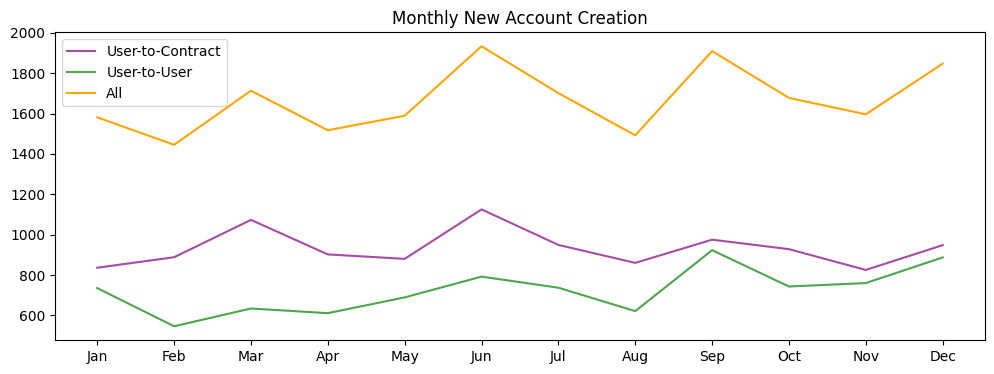

KeyError: "['total'] not found in axis"

In [463]:
plt.figure(figsize=(12, 4))

user_to_contract = transactions_per_month[transactions_per_month['transactions_purpose'] == 'User-to-Contract']
user_to_user = transactions_per_month[transactions_per_month['transactions_purpose'] == 'User-to-User']

plt.plot(user_to_contract['first_transaction_time'], user_to_contract['from_address'],
         label='User-to-Contract', color='purple', alpha=0.7)
plt.plot(user_to_user['first_transaction_time'], user_to_user['from_address'],
         label='User-to-User', color='green', alpha=0.7)
plt.plot(transactions_per_month['first_transaction_time'], transactions_per_month['total'],
         label='All', color='orange')

plt.title('Monthly New Account Creation')
plt.legend()
plt.show();


df.drop(columns=['total'], axis=1, inplace=True)

The graph demonstrates monthly new wallet creation across contract, user-to-user, and total categories:

- Contract wallets strongly influence the total trend, with relatively consistent fluctuations.
- User-to-user wallets show sharper variations, and their peaks (e.g., in September) significantly contribute to the total.
- The total wallet creation generally mirrors contract trends but is visibly impacted by user-to-user spikes during high-activity months.

**This indicates that contract wallet creation is the dominant factor in the total, with notable contributions from user-to-user growth during specific months.**

### **8. What is the Values Distribution of Transaction by Category?**

- "Zero": Transactions with 0 (e.g., = 0.0 ETH)
- "Micro": Transactions with very small amounts (e.g., < 0.001 ETH).
- "Small": Transactions with small amounts (e.g., 0.001 to 0.1 ETH).
- "Medium": Transactions with medium amounts (e.g., 0.1 to 1 ETH).
- "Large": Transactions with large amounts (e.g., 1 to 10 ETH).
- "Whale": Transactions with very large amounts (e.g., > 10 ETH).

In [190]:
df['eth_value'] = df['value'] /1e18

df['value_category'] = 'Zero'

bins = [0, 0.001, 0.01, 0.1, 1, 10, float('inf')]
labels = ['Micro', 'Small', 'Medium', 'Large', 'Whale', 'Mega Whale']

df.loc[df['eth_value'] > 0, 'value_category'] = pd.cut(
    df['eth_value'], bins=bins, labels=labels
)

In [194]:
general_value_category_perc = df['value_category'].value_counts(normalize=True) * 100

user_to_user_value_category_perc = (
    df[df['transactions_purpose'] == 'User-to-User']['value_category']
    .value_counts(normalize=True) * 100
)

contract_to_user_value_category_perc = (
    df[df['transactions_purpose'] == 'User-to-Contract']['value_category']
    .value_counts(normalize=True) * 100
)

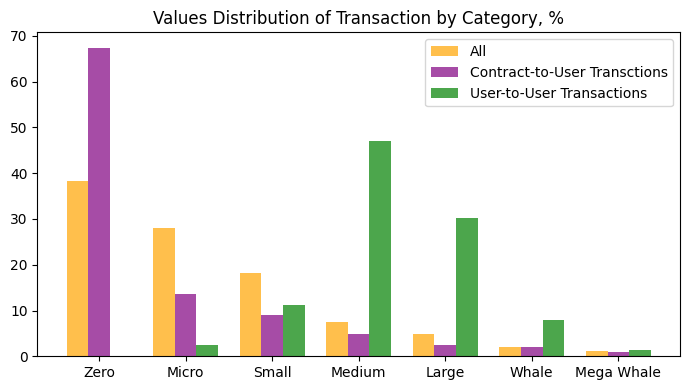

In [196]:
categories = ['Zero', 'Micro', 'Small', 'Medium', 'Large', 'Whale', 'Mega Whale']

index = np.arange(len(categories))
bar_width = 0.25  

user_to_user_value_category_perc = (
    user_to_user_value_category_perc
    .reindex(categories, fill_value=0)
)

plt.figure(figsize=(7, 4))

plt.bar(index - bar_width, general_value_category_perc, bar_width,
        label='All', color='orange', alpha=0.7)
plt.bar(index, contract_to_user_value_category_perc, bar_width,
        label='Contract-to-User Transctions', color='purple', alpha=0.7)
plt.bar(index + bar_width, user_to_user_value_category_perc, bar_width,
        label='User-to-User Transactions', color='green', alpha=0.7)


plt.xticks(index, categories)
plt.title('Values Distribution of Transaction by Category, %')
plt.legend()

plt.tight_layout()
plt.show()

### **9. Gas Usage Analysis**

#### **9.1 Estimated Gas.**

In [134]:
gas_median_user_to_user = df[df['transactions_purpose'] == 'User-to-User'].gas.median()
gas_median_user_to_user

np.float64(21000.0)

In [198]:
gas_median_user_to_contract = df[df['transactions_purpose'] == 'User-to-Contract'].gas.median()
gas_median_user_to_contract

np.float64(92218.0)

In [199]:
gas_median_contract = df[df['transactions_purpose'] == 'Contract'].gas.median()
gas_median_contract

np.float64(2131637.0)

#### **9.2 Used Gas.**

In [139]:
used_gas_median_user_to_user = df[df['transactions_purpose'] == 'User-to-User'].receipt_gas_used.median()
used_gas_median_user_to_user

np.float64(21000.0)

In [200]:
used_gas_median_user_to_contract = df[df['transactions_purpose'] == 'User-to-Contract'].receipt_gas_used.median()
used_gas_median_user_to_contract

np.float64(48897.0)

In [201]:
used_gas_median_contract = df[df['transactions_purpose'] == 'Contract'].receipt_gas_used.median()
used_gas_median_contract

np.float64(1984655.0)

#### 1. User-to-User Transactions
- Estimated Gas: 21,000
- Used Gas: 21,000
These transactions represent the most basic Ethereum operations, typically involving simple ETH transfers between users. The gas usage is fixed and predictable due to the absence of complex computations.
#### 2. User-to-Contract Transactions
- Estimated Gas: 92,218
- Used Gas: 48,897
These transactions are more complex as they involve calling smart contract functions. Estimated gas is higher to account for potential branching, loops, or other computations in the contract. However, the actual gas used reflects the simpler logic executed in most cases, such as straightforward function calls or token transfers.
#### 3. Contract Transactions
- Estimated Gas: 2,131,637
- Used Gas: 1,984,655
These transactions are initiated by smart contracts themselves and involve highly complex operations. Contracts often perform multiple tasks, such as interacting with other contracts, executing loops, or managing large datasets. The high gas usage reflects the intricate, multitasking nature of contract execution.  
#### Difference Between Estimated and Used Gas
Why the Difference?
Estimated gas is calculated for the worst-case scenario to ensure the transaction has enough gas to succeed. Used gas reflects the actual operations performed, which are often simpler than the estimated logic, leading to lower consumption. This ensures transactions are reliable without risking failure due to underestimation.
In summary, gas usage increases with transaction complexity: simple user-to-user transfers are predictable, user-to-contract calls involve additional computational costs, and contract-initiated transactions are the most resource-intensive due to their multitasking nature.








### **10. Gas Usage Difference** 

In [207]:
df['gas_difference'] = df['gas'] - df['receipt_gas_used']

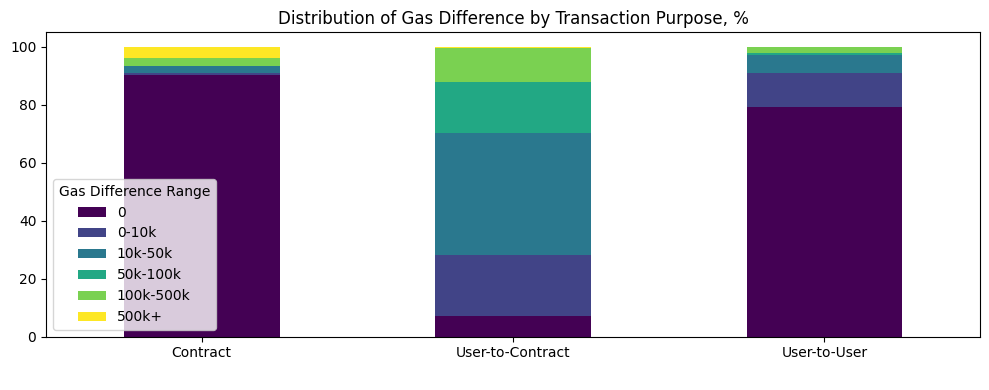

In [462]:
bins = [-1, 0, 10_000, 50_000, 100_000, 500_000, df['gas_difference'].max()]
labels = ['0', '0-10k', '10k-50k', '50k-100k', '100k-500k', '500k+']
df['gas_diff_bins'] = pd.cut(df['gas_difference'], bins=bins, labels=labels)

percentage_data = df.groupby(['transactions_purpose', 'gas_diff_bins'],observed=False).size().unstack(fill_value=0)
percentage_data = percentage_data.div(percentage_data.sum(axis=1), axis=0) * 100

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 4), colormap="viridis")
plt.title('Distribution of Gas Difference by Transaction Purpose, %')
plt.xlabel(' ')
plt.xticks(rotation=0)
plt.legend(title='Gas Difference Range')
plt.tight_layout()
plt.show()

- Contracts: Nearly all transactions have no gas difference (0), indicating that estimated and used gas are closely aligned. This reflects the high predictability of contract-initiated tasks.

- User-to-Contract: A significant portion of transactions show gas differences in the range of 10k-50k and 50k-100k, highlighting the complexity and variability of contract executions. Only a small percentage have no gas difference.

- User-to-User: The majority of transactions have no gas difference, consistent with the simplicity of these operations. However, small differences (0-10k) appear occasionally due to minor adjustments.

#### Gas differences increase with transaction complexity.  
User-to-Contract transactions show the highest variability, reflecting the dynamic nature of contract logic execution compared to the predictability of User-to-User or Contract-initiated transactions.**

### **11. Transactions Type Analysis**

- Type 0: Simple, uses gasPrice.
- Type 1: Adds access lists for gas optimization.
- Type 2: Implements EIP-1559 fee structure for improved efficiency.


In [285]:
df['transaction_type'].value_counts(normalize=True)

transaction_type
2    0.72565
0    0.27355
1     0.0008
Name: proportion, dtype: Float64

In [304]:
transactions_type_percentage = (
    df[['transactions_purpose', 'transaction_type']]
    .groupby(['transactions_purpose', 'transaction_type'])['transaction_type']
    .count()
    .reset_index(name='transaction_count')
)

transactions_type_percentage['percentage'] = (
    transactions_type_percentage['transaction_count'] /
    transactions_type_percentage.groupby('transactions_purpose')['transaction_count'].transform('sum') * 100
)

In [308]:
transactions_type_percentage

,transactions_purpose,transaction_type,transaction_count,percentage
0,Contract,0,5,3.759398
1,Contract,2,128,96.240602
2,User-to-Contract,0,2319,20.725713
3,User-to-Contract,1,7,0.062561
4,User-to-Contract,2,8863,79.211726
5,User-to-User,0,3147,36.264116
6,User-to-User,1,9,0.103711
7,User-to-User,2,5522,63.632173


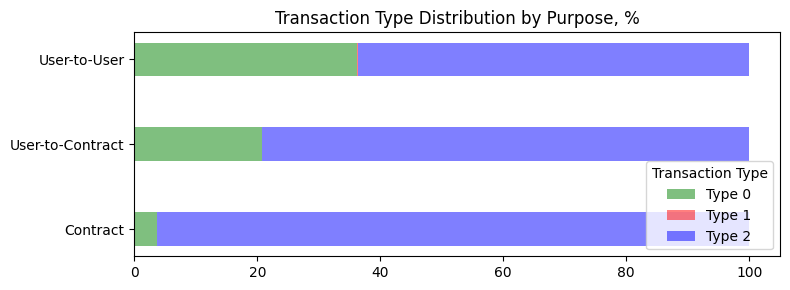

In [461]:
pivot_data = transactions_type_percentage.pivot(
    index='transactions_purpose', 
    columns='transaction_type', 
    values='percentage'
).fillna(0)

bar_height = 0.4
categories = pivot_data.index
types = pivot_data.columns
values = [pivot_data[t] for t in types]

plt.figure(figsize=(8, 3))
bars = plt.barh(categories, values[0], color='green', alpha=0.5, height=bar_height, label='Type 0')
bars = plt.barh(categories, values[1], left=values[0], color='red', alpha=0.5, height=bar_height, label='Type 1')
bars = plt.barh(categories, values[2], left=values[0] + values[1], color='blue', alpha=0.5, height=bar_height, label='Type 2')

plt.title('Transaction Type Distribution by Purpose, %')
plt.legend(title='Transaction Type', loc='lower right')
plt.tight_layout()

plt.show()

The distribution of transaction types shows clear differences across categories:

- Contract Transactions:

Dominated by Type 2 (96.24%), indicating contract-specific operations.
Minimal presence of Type 0 (3.76%), likely for simpler tasks.
- User-to-Contract Transactions:

Majority are Type 2 (79.21%), reflecting the complexity of interactions with contracts.
Type 0 accounts for 20.73%, with almost no Type 1 (0.06%).
- User-to-User Transactions:

Predominantly Type 2 (63.63%), suggesting more advanced transfers.
Significant Type 0 (36.26%) for straightforward transfers.
Negligible Type 1 (0.10%).
This highlights that Type 2 transactions dominate contract interactions, while user-to-user transactions have a higher proportion of simpler Type 0 transfers.

### **12. What are TOP-25 Contract Addresses?**

In [330]:
top25_contracts = (
    df[(df['function'] != 'Transfer') & (df['to_address'] != 'Contract')]
    .to_address.value_counts()
    .head(25)
    .reset_index()
)

top25_contracts.columns = ['to_address', 'transaction_count']

In [331]:
top25_contracts.head(3)

,to_address,transaction_count
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735


***Api does not have information about address's owners. It was collected address by address with Etherscan interface and ChatGPT help.***

In [333]:
contract_dict = {
    '0xdac17f958d2ee523a2206206994597c13d831ec7': 'USDT (Tether) coin',
    '0x32400084c286cf3e17e7b677ea9583e60a000324': 'zkSync: Layer 2 Bridge',
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC (USD Coin)',
    '0x881d4032abe4188e2237efcd27ab435e81fc6bb1': 'MetaMask Swap Router',
    '0xae0ee0a63a2ce6baeeffe56e7714fb4efe48d419': 'StarkGate ETH Bridge',
    '0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad': 'Uniswap: Universal Router',
    '0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce': 'Shiba Inu (SHIB) token',
    '0xabea9132b05a70803a4e85094fd0e1800777fbef': 'zkSync: Layer 2 Bridge',
    '0x7a250d5630b4cf539739df2c5dacb4c659f2488d': 'Uniswap V2: Router 2',
    '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b': 'Uniswap: Universal Router 2',
    '0x06450dee7fd2fb8e39061434babcfc05599a6fb8': 'XEN Crypto (XEN) token',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0': 'Matic Token (MATIC) token',
    '0x881d40237659c251811cec9c364ef91dc08d300c': 'MetaMask: Swap Router',
    '0x514910771af9ca656af840dff83e8264ecf986ca': 'ChainLink Token (LINK)',
    '0xdef1c0ded9bec7f1a1670819833240f027b25eff': '0x Protocol: Exchange Proxy',
    '0x00000000219ab540356cbb839cbe05303d7705fa': 'Beacon Deposit Contract',
    '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'Wrapped Ether (WETH) token',
    '0xe66b31678d6c16e9ebf358268a790b763c133750': '0x: Coinbase Wallet Proxy',
    '0x1a0ad011913a150f69f6a19df447a0cfd9551054': 'Zora: Bridge',
    '0xd4307e0acd12cf46fd6cf93bc264f5d5d1598792': 'Base, Introduced token',
    '0x6b175474e89094c44da98b954eedeac495271d0f': 'Dai Stablecoin (DAI)',
    '0x0000000000664ceffed39244a8312bd895470803': 'ENS: ETH Registrar Controller',
    '0x3506424f91fd33084466f402d5d97f05f8e3b4af': 'Chiliz (CHZ) token',
    '0xd19d4b5d358258f05d7b411e21a1460d11b0876f': 'Linea: L1 Message Service',
    '0x4d224452801aced8b2f0aebe155379bb5d594381': 'ApeCoin (APE) token'
}


In [334]:
top25_contracts['decoded_contracts'] = top25_contracts['to_address'].map(contract_dict)

In [358]:
def get_contract_functionality(decoded_contracts):
    if isinstance(decoded_contracts, str):
        decoded_contracts = decoded_contracts.lower()
        if 'tether' in decoded_contracts or 'usd coin' in decoded_contracts or 'dai' in decoded_contracts:
            return 'Stablecoin'
        elif 'uniswap' in decoded_contracts or 'metamask' in decoded_contracts:
            return 'Router'
        elif 'bridge' in decoded_contracts:
            return 'Bridge'
        elif 'token' in decoded_contracts:
            return 'Token (NFT)'
        elif 'ens' in decoded_contracts or 'proxy' in decoded_contracts or 'beacon' in decoded_contracts:
            return 'Infrastructure'
        else:
            return 'Other'
    return 'Other'


In [336]:
top25_contracts['contract_functionality'] = top25_contracts['decoded_contracts'].apply(get_contract_functionality)

In [419]:
top25_contracts.head(3)

,to_address,transaction_count,decoded_contracts,contract_functionality
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128,USDT (Tether) coin,Stablecoin
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859,zkSync: Layer 2 Bridge,Bridge
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735,USDC (USD Coin),Stablecoin


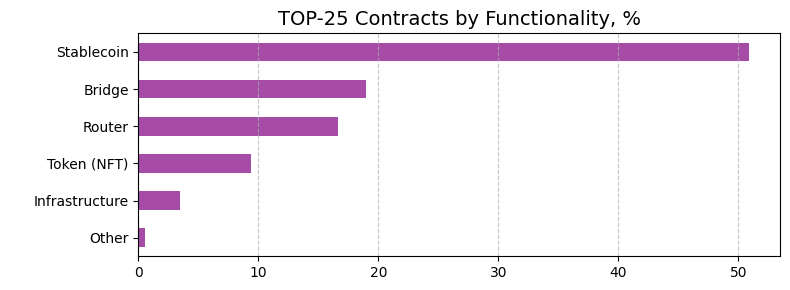

In [460]:
category_percentage = top25_contracts.groupby('contract_functionality')['transaction_count'].sum() / top25_contracts['transaction_count'].sum() * 100

plt.figure(figsize=(8, 3))
category_percentage.sort_values().plot(kind='barh', color='purple', alpha=0.7)

plt.title('TOP-25 Contracts by Functionality, %', fontsize=14)
plt.ylabel('  ', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### CONCLUSION

### **13. Is There a Statistically Significant Difference in Gas Difference Between Stablecoin Contracts and Token Contracts??**

**Choose data with User-to-Contract purpose and only necessary columns:**

In [437]:
user_to_contract_gas_diff = df[df['transactions_purpose'] == 'User-to-Contract'][['to_address', 'gas_difference']]
user_to_contract_gas_diff.head(3)

,to_address,gas_difference
0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,19704
1,0xdef1c0ded9bec7f1a1670819833240f027b25eff,31296
2,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,90582


For building a distribution each value in column 'gas_difference' is needed.  
As a contract_dict has only 25 identified addresses, unidentified addresses return NaN.  
It has no impact on the next research, so there is no need to handle NaN.

In [438]:
user_to_contract_gas_diff['decoded_contracts'] = user_to_contract_gas_diff['to_address'].map(contract_dict)
user_to_contract_gas_diff['contract_functionality'] = user_to_contract_gas_diff['decoded_contracts'].apply(get_contract_functionality)
user_to_contract_gas_diff.head(3)

,to_address,gas_difference,decoded_contracts,contract_functionality
0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,19704,USDC (USD Coin),Stablecoin
1,0xdef1c0ded9bec7f1a1670819833240f027b25eff,31296,0x Protocol: Exchange Proxy,Infrastructure
2,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,90582,NaN,Other


Distinguish gas difference for stablecoin functionality contracts and token (NFT) functionality contracts:

In [510]:
stablecoin_distribution = user_to_contract_gas_diff[(user_to_contract_gas_diff['contract_functionality'] == 'Stablecoin') & (user_to_contract_gas_diff['gas_difference'] != 0)].gas_difference
token_distribution = user_to_contract_gas_diff[(user_to_contract_gas_diff['contract_functionality'] == 'Token (NFT)')  & (user_to_contract_gas_diff['gas_difference'] != 0)].gas_difference

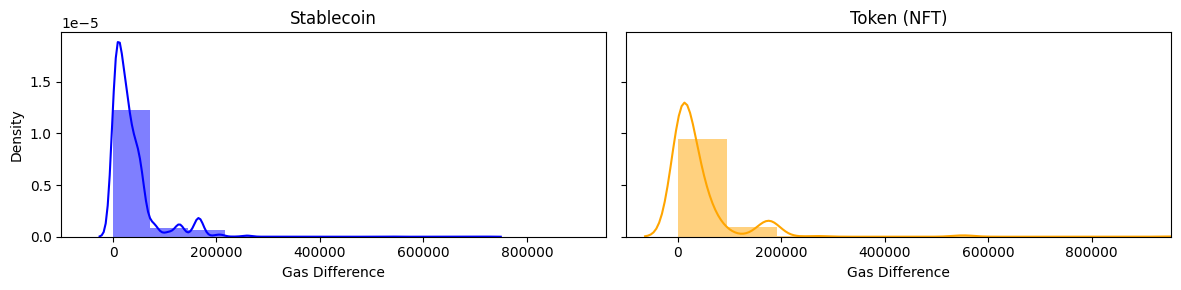

In [468]:
x_max = max(stablecoin_distribution.max(), token_distribution.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

axes[0].hist(stablecoin_distribution, bins=10, density=True, alpha=0.5, color='blue', label='Stablecoin')
sns.kdeplot(stablecoin_distribution, ax=axes[0], color='blue')
axes[0].set_title('Stablecoin')
axes[0].set_xlabel('Gas Difference')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-100000, x_max)

axes[1].hist(token_distribution, bins=10, density=True, alpha=0.5, color='orange', label='Token (NFT)')
sns.kdeplot(token_distribution, ax=axes[1], color='orange')
axes[1].set_title('Token (NFT)')
axes[1].set_xlabel('Gas Difference')
axes[1].set_xlim(-100000, x_max)

plt.tight_layout()
plt.show()


#### **13.1 Kernel Dencity Estimation (KDE) Plot of Gas Difference by Stablecoin and Token (NFT) Contracts**

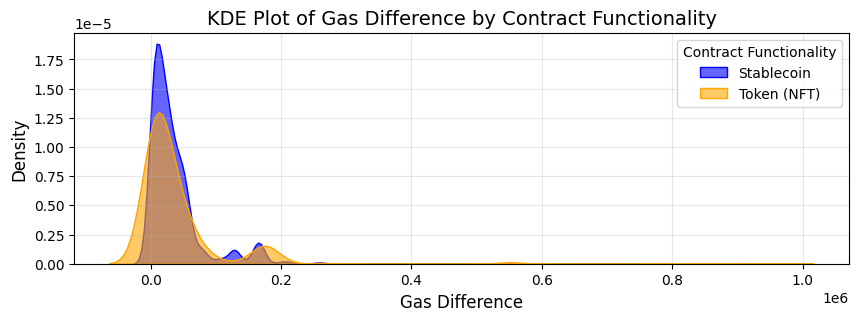

In [465]:
plt.figure(figsize=(10, 3))
sns.kdeplot(stablecoin_distribution, label='Stablecoin', fill=True, alpha=0.6, color='blue')
sns.kdeplot(token_distribution, label='Token (NFT)', fill=True, alpha=0.6, color='orange')

plt.title("KDE Plot of Gas Difference by Contract Functionality", fontsize=14)
plt.xlabel("Gas Difference", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Contract Functionality", fontsize=10)
plt.grid(True, alpha=0.3)

plt.show()

Despite the visual similarity of the KDE Plot of Gas Difference, a statistical test is required to confirm or refute the hypothesis.  
Distributions are not normall, so let's try to normalize them.

#### **13.2 Deleteing Outliers in the Stablecoin and Token (NFT) Gas Difference Distributions**

Choose IQR Method instead of 3*STD Method becuse it is less sensitive to outliers:

**Stablecoin Distribution**

In [513]:
Q1 = stablecoin_distribution.quantile(0.25)
Q3 = stablecoin_distribution.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stablecoin_distribution = stablecoin_distribution[(stablecoin_distribution >= lower_bound) & (stablecoin_distribution <= upper_bound)]

**Token (NFT) Distribution**

In [514]:
Q1 = token_distribution.quantile(0.25)
Q3 = token_distribution.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

token_distribution = token_distribution[(token_distribution >= lower_bound) & (token_distribution <= upper_bound)]

#### **13.3 Normalizing the Stablecoin and Token (NFT) Gas Difference Distributions**

In [515]:
stablecoin_distribution_log = np.log1p(stablecoin_distribution)
token_distribution_log = np.log1p(token_distribution)

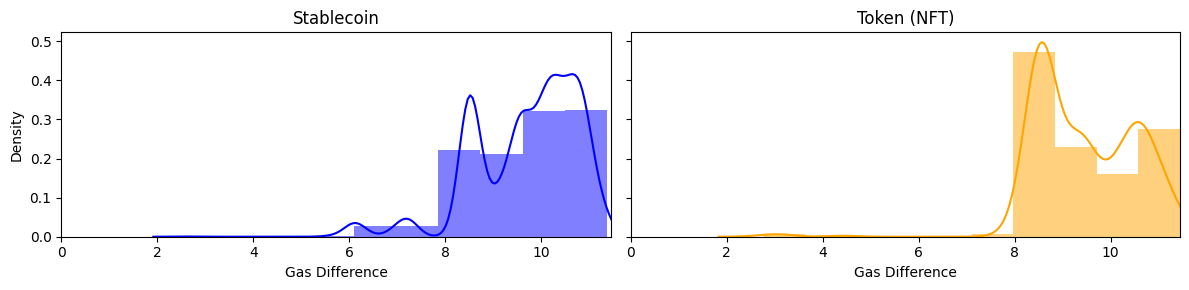

In [516]:
x_max = max(stablecoin_distribution_log.max(), token_distribution_log.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

axes[0].hist(stablecoin_distribution_log, bins=10, density=True, alpha=0.5, color='blue', label='Stablecoin')
sns.kdeplot(stablecoin_distribution_log, ax=axes[0], color='blue')
axes[0].set_title('Stablecoin')
axes[0].set_xlabel('Gas Difference')
axes[0].set_ylabel('Density')
axes[0].set_xlim(0, x_max)

axes[1].hist(token_distribution_log, bins=10, density=True, alpha=0.5, color='orange', label='Token (NFT)')
sns.kdeplot(token_distribution_log, ax=axes[1], color='orange')
axes[1].set_title('Token (NFT)')
axes[1].set_xlabel('Gas Difference')
axes[1].set_xlim(0, x_max)

plt.tight_layout()
plt.show()


Since the log-transformed distributions did not become normal, we will use the Mann-Whitney test for the statistical analysis.

#### **13.4 Hypotheses Formulation:**

**Null Hypothesis (H₀):**  
The gas difference is the same for stablecoin and token contracts.  
There is no statistically significant difference between the two groups.

**Alternative Hypothesis (H₁):**  
The gas difference differs between stablecoin and token contracts.  
There may be a tendency for systematic overestimation or underestimation of gas usage depending on the contract type.

In [520]:
stat, p_value = mannwhitneyu(stablecoin_distribution, token_distribution, alternative='two-sided')

print(f"U-Statistic: {stat}")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject H₀: There is a statistically significant difference between the groups.")
else:
    print("fFail to reject H₀: There is no statistically significant difference between the groups.")

U-Statistic: 1026028.0
P-Value: 1.1735901454647512e-09
Reject H₀: There is a statistically significant difference between the groups.


In [521]:
stablecoin_distribution.mean(), stablecoin_distribution.median()

(np.float64(24632.57210965435), np.float64(21012.0))

In [522]:
token_distribution.mean(), token_distribution.median()

(np.float64(20757.908571428572), np.float64(11759.0))

Results indicate that token contracts evaluate gas usage more accurately compared to stablecoin contracts, based on both the mean and median values.

- **Mean:** Stablecoin contracts have a higher mean gas difference (24,632) compared to token contracts (20,757). This suggests that, overall, stablecoin contracts tend to overestimate the required gas.

- **Median:** Stablecoin contracts also have a significantly higher median (21,012) compared to token contracts (11,759). This indicates that the difference is systematic across most transactions, not just due to outliers.

**Conclusion:** The Mann-Whitney test confirms that this difference is statistically significant. Therefore, token contracts generally provide a better estimate of gas usage, while stablecoin contracts tend to have a greater discrepancy between estimated and actual gas.






